In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [172]:
df = pd.read_parquet('../data/raw_data/df_comments_translated.parquet')

In [173]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import re

# Descargar recursos de NLTK si no están descargados
nltk.download('wordnet')
nltk.download('stopwords')

# Inicializar el lematizador en inglés
lemmatizer = WordNetLemmatizer()

# Cargar las stopwords en inglés
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if text is None:
        return None
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/ivanseldasp/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ivanseldasp/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [174]:
# Preprocess text for sentiment analysis
df['clean_text'] = df['translation'].apply(preprocess_text)

In [175]:
# Sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text, model):
    if type(text) != type('string'):
        return None
    sentiment = model.polarity_scores(text)
    return sentiment['compound']

analyzer = SentimentIntensityAnalyzer()

# Apply the sentiment analysis only to English comments and create a new 'sentiment' column
df['sentiment_trans'] = df.apply(lambda row: get_sentiment(row['translation'], analyzer), axis=1)

# df.to_parquet('../data/clean_data/df_trans_sent_comments.parquet', index=False)

In [176]:
plt.figure(figsize=(20,15))
import seaborn as sns

def sentiment_description(sentiment):
    if sentiment is None:
        return None
    if sentiment < 0:
        return('negative')
    if sentiment > 0:
        return('positive')
    else:
        return('neutral')

df['sentiment_text_trans'] = df['sentiment_trans'].apply(sentiment_description)

<Figure size 1440x1080 with 0 Axes>

In [180]:
plt.figure(figsize=(12,8))
sentiment_counts = df['sentiment_trans'].value_counts()
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%')# Optional: Add a title
plt.title('Sentiment Distribution')
plt.show();

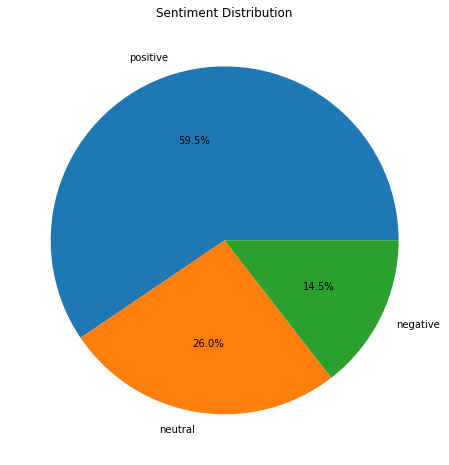

In [ ]:
plt.figure(figsize=(12,8))
sentiment_counts = df['sentiment_text_trans'].value_counts()
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%')# Optional: Add a title
plt.title('Sentiment Distribution')
plt.show();

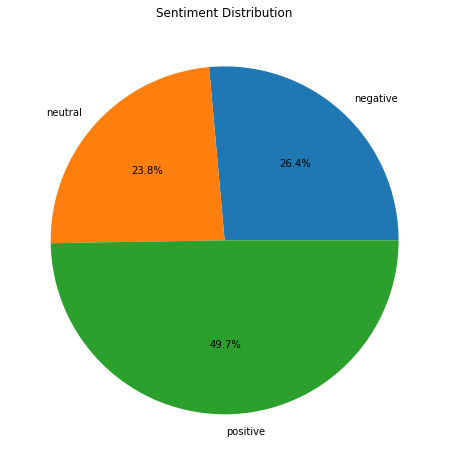

In [182]:
likes_per_sentiment = df.groupby('sentiment_text_trans')['like_count'].sum()

plt.figure(figsize=(12,8))
plt.pie(likes_per_sentiment, labels=likes_per_sentiment.index, autopct='%1.1f%%')# Optional: Add a title
plt.title('Sentiment Distribution')
plt.show();

In [185]:
from transformers import pipeline

classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=1)

sentiment_list = []
for sentence in df[df['sentiment_trans'] == 0]['translation'].iloc[:1500]:
    result = classifier(sentence)[0]
    sentiment_list.append(result)

/home/ivanseldasp/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [186]:
sentiment_label = [sentiment_list[n][0]['label'] for n in range(0, len(sentiment_list))]

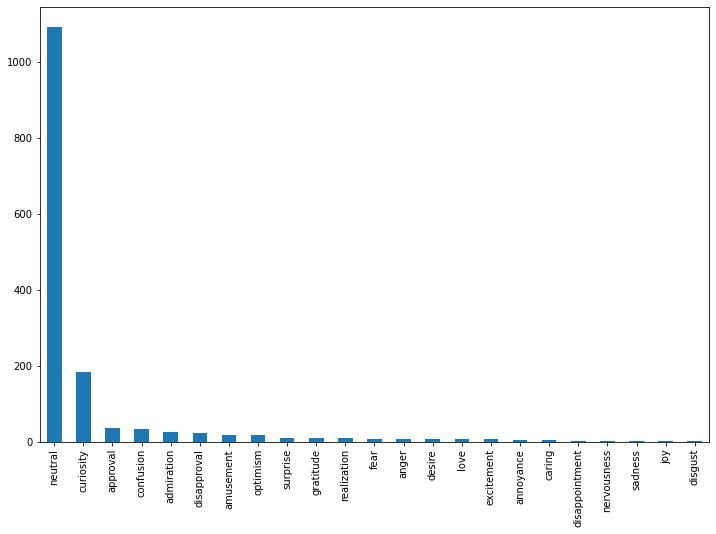

In [187]:
df_label = pd.Series(sentiment_label)

plt.figure(figsize=(12,8))
df_label.value_counts().plot(kind='bar')
plt.show();